In [2]:
import pandas as pd

df = pd.read_csv("../data/processed/cleaned_readmission.csv")
target = "readmitted_30"
y = df[target]
X = df.drop(columns=[target])
print(X.shape, y.shape)


(101766, 43) (101766,)


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

In [5]:
from sklearn.metrics import classification_report, roc_auc_score
log_reg.fit(X_train, y_train)

y_val_pred = log_reg.predict(X_val)
y_val_prob = log_reg.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))

y_val_pred_03 = (y_val_prob >= 0.3).astype(int)
print(classification_report(y_val, y_val_pred_03))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77     13561
           1       0.17      0.54      0.26      1704

    accuracy                           0.65     15265
   macro avg       0.54      0.60      0.52     15265
weighted avg       0.84      0.65      0.72     15265

ROC-AUC: 0.6468344392733512
              precision    recall  f1-score   support

           0       0.95      0.04      0.07     13561
           1       0.11      0.98      0.20      1704

    accuracy                           0.14     15265
   macro avg       0.53      0.51      0.14     15265
weighted avg       0.86      0.14      0.09     15265



### Threshold Selection and Tradeoffs

The logistic regression model outputs a probability representing the estimated risk of 30-day readmission. A decision threshold is then applied to convert this probability into a binary prediction.

Using the default threshold of 0.5 results in moderate recall, as the model only flags patients it is highly confident will be readmitted. Lowering the threshold makes the model more aggressive, increasing recall by identifying a larger proportion of high-risk patients, but at the cost of reduced precision due to more false positives.

In this clinical context, prioritizing recall is appropriate, as failing to identify a high-risk patient (false negative) is more costly than flagging additional patients for further review.


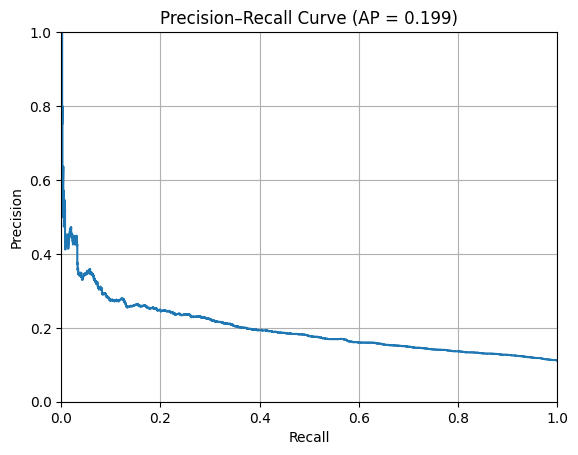

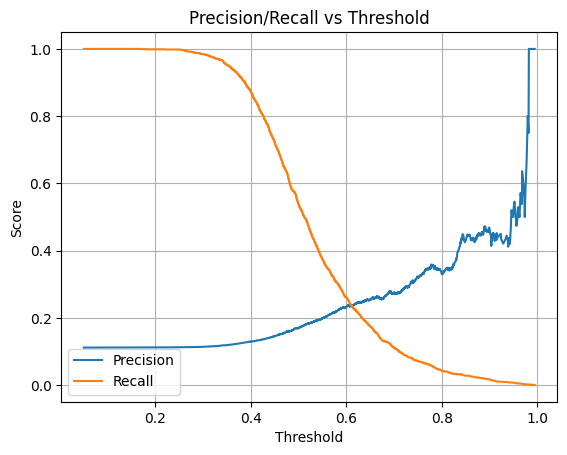

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

prec, rec, _ = precision_recall_curve(y_val, y_val_prob)
ap = average_precision_score(y_val, y_val_prob)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.show()

prec, rec, thresh = precision_recall_curve(y_val, y_val_prob)

plt.figure()
plt.plot(thresh, prec[:-1], label="Precision")
plt.plot(thresh, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold")
plt.grid(True)
plt.legend()
plt.show()



Lowering the decision threshold increases recall by identifying a larger proportion of high-risk patients, but this comes at the cost of reduced precision due to a higher number of false positives.